##### Imports & Global Variables

In [10]:
# %pip install -r requirements.txt

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

from regime_detection import KAMA
from regime_detection import MarkovSwitchingModel

In [12]:
sdte = datetime(1990, 1, 1)
edte = datetime(2018, 1, 1)

# Getting Data

In [13]:
symbol_name_dict = pd.read_csv('data/inputs/fmp_index_list.csv').set_index('symbol')['name'].to_dict()
index_data = pd.read_csv('data/processed/index_data.csv', index_col=0, header=[0, 1], parse_dates=True)

index_close_cols = index_data.columns[index_data.columns.get_level_values(1) == 'close']
index_close_prices = index_data[index_close_cols].droplevel(1, axis=1).rename(columns=symbol_name_dict)

sp500_prices = index_close_prices['S&P 500'].dropna()

In [14]:
sp500_log_returns = np.log(sp500_prices.loc[sdte:edte]).diff().dropna()
sp500_log_returns = pd.DataFrame({'returns': sp500_log_returns})

# Testing KAMA

In [15]:
kama = KAMA(n=10, n_fast=2, n_slow=30)
sp500_kama = kama.calculate_kama(sp500_prices)
# pd.concat([sp500_prices, sp500_kama[0], sp500_kama[1], sp500_kama[2]], axis=1).head(11)

px.line(pd.concat([sp500_prices, sp500_kama[0]], axis=1).tail(252*5))

# Testing MSR

### Fitting Model 

Fitting Markov Switching Model on S&P 500 data...
Running Gibbs sampler: 600 total iterations
Burnin: 100, Samples: 500, Thin: 1
Iteration 100/600
Iteration 200/600
Iteration 300/600
Iteration 400/600
Iteration 500/600
Iteration 600/600

Gibbs sampling completed!
Regime 0: μ=0.000709, β=-0.0010, σ=0.006564
Regime 1: μ=-0.000671, β=-0.0115, σ=0.017295

ANALYSIS RESULTS FOR S&P 500

Estimated Parameters:
Regime   μ (Mean)     β (AR)     σ (Vol)     
---------------------------------------------
Regime 0  0.000709    -0.0010   0.006564   
Regime 1  -0.000671   -0.0115   0.017295   

Transition Probabilities:
From\To  Reg 0  Reg 1
---------------------
Regime 0  0.983  0.017
Regime 1  0.038  0.962

Expected Regime Durations:
Regime 0 (Regime 0): 59.7 days
Regime 1 (Regime 1): 26.5 days

Regime Classification:
Estimated Regime 0 periods: 4948 days (70.1%)
Estimated Regime 1 periods: 2107 days (29.9%)
Number of regime changes: 115

DETAILED REGIME ANALYSIS - S&P 500

Low Volatility (Regime 0

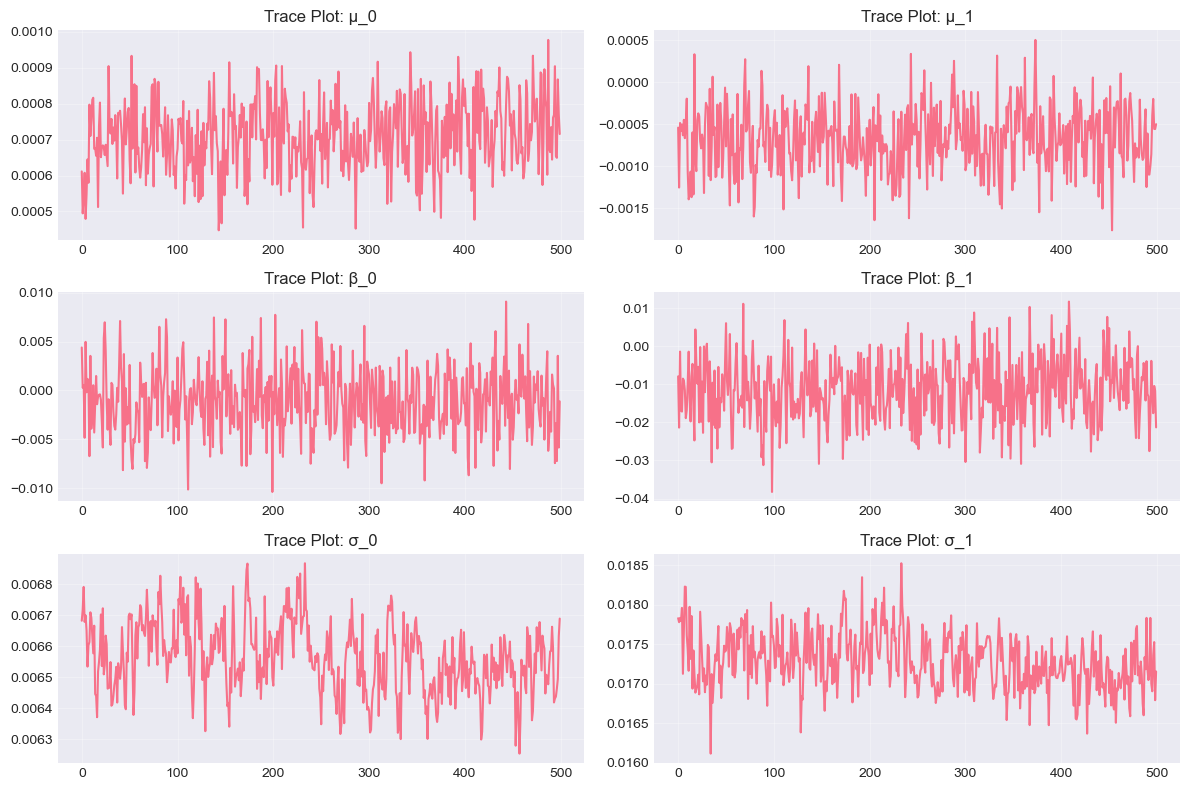

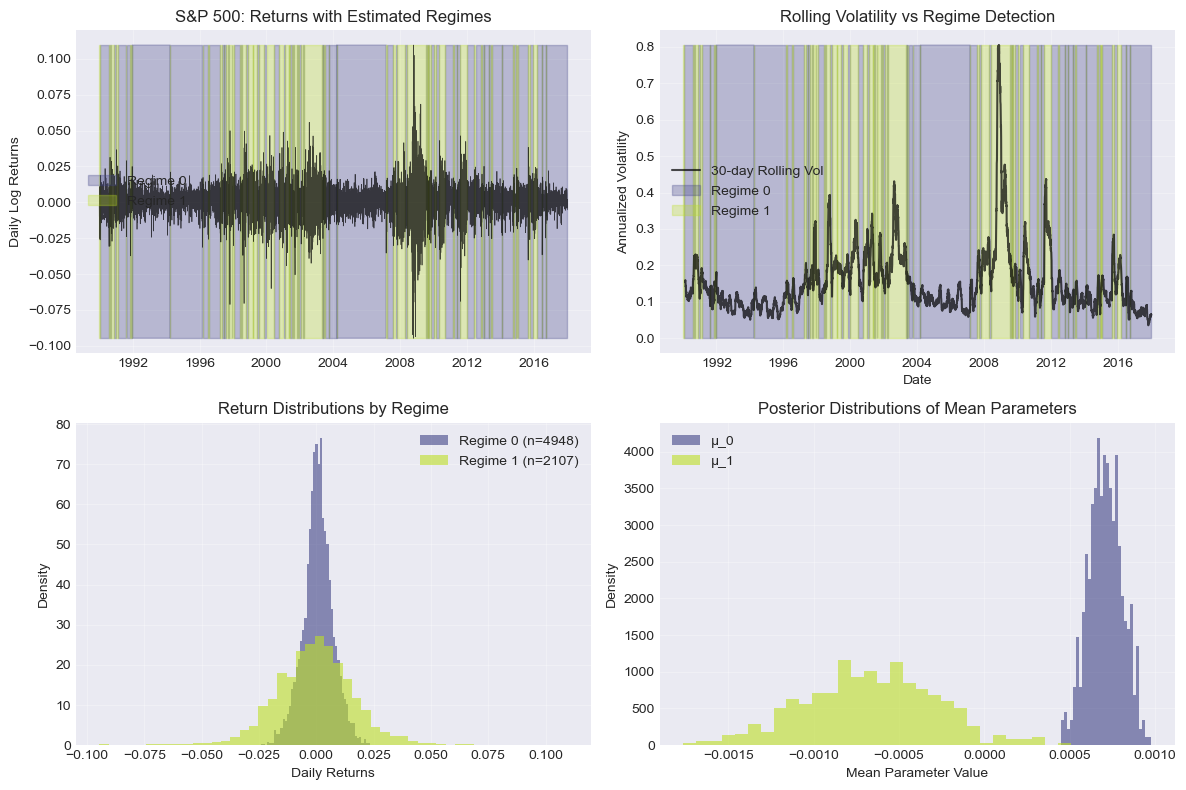

CPU times: total: 15min 26s
Wall time: 4min 37s


In [20]:
%%time
sdte = datetime(1990, 1, 1)
edte = datetime(2018, 1, 1)
# edte = sp500_prices.index[-1]
sp500_log_returns = np.log(sp500_prices.loc[sdte:edte]).diff().dropna()
sp500_log_returns = pd.DataFrame({'returns': sp500_log_returns})

# Params
n_regimes=2
burnin=100
n_samples=500
thin=1

# Intialize the model
model = MarkovSwitchingModel(n_regimes=n_regimes)
model.set_priors(
    mean_prior_mean=0.0,
    mean_prior_var=0.01,
    beta_prior_mean=0.0,
    beta_prior_var=0.3,
    sigma_prior_shape=3.0,
    sigma_prior_scale=0.0001,
    transition_prior_alpha=8.0
)
# Fit the model
print("Fitting Markov Switching Model on S&P 500 data...")
model.fit(sp500_log_returns['returns'], n_samples=n_samples, burnin=burnin, thin=thin, verbose=True)

# Run comprehensive analysis
regime_probs = model.analyze_results(sp500_log_returns, data_name="S&P 500")

# Detailed regime characteristics
regime_classification = model.regime_characteristics(sp500_log_returns, regime_probs, data_name="S&P 500")

# Model diagnostics
model.diagnostics(sp500_log_returns, regime_probs, data_name="S&P 500", trace_plots=True)

# Create visualizations
model.plot_results(sp500_log_returns, regime_probs, data_name="S&P 500")

# Save Model as pkl file
model.save_model(f'saved_models/sp500_MSR_{n_regimes}-regime_{burnin}-{n_samples}-{thin}.pkl', burnin, n_samples, thin)

### Loading Pre-saved Model


ANALYSIS RESULTS FOR S&P 500

Estimated Parameters:
Regime   μ (Mean)     β (AR)     σ (Vol)     
---------------------------------------------
Regime 0  0.000804    -0.0013   0.005521   
Regime 1  -0.000013   -0.0019   0.011165   
Regime 2  -0.001250   -0.0101   0.026022   

Transition Probabilities:
From\To  Reg 0  Reg 1  Reg 2
----------------------------
Regime 0  0.973  0.023  0.004
Regime 1  0.028  0.962  0.010
Regime 2  0.020  0.055  0.925

Expected Regime Durations:
Regime 0 (Low Vol): 36.9 days
Regime 1 (High Vol): 26.6 days
Regime 2 (Extreme Vol): 13.3 days

Regime Classification:
Estimated Regime 0 periods: 3526 days (50.0%)
Estimated Regime 1 periods: 2994 days (42.4%)
Estimated Regime 2 periods: 535 days (7.6%)
Number of regime changes: 143

DETAILED REGIME ANALYSIS - S&P 500

Low Volatility (Regime 0):
  Observations: 3526 (50.0%)
  Mean Return: 0.000848 (21.37% annualized)
  Volatility: 0.005452 (8.66% annualized)
  Min Return: -0.019985
  Max Return: 0.021980
  Skewnes

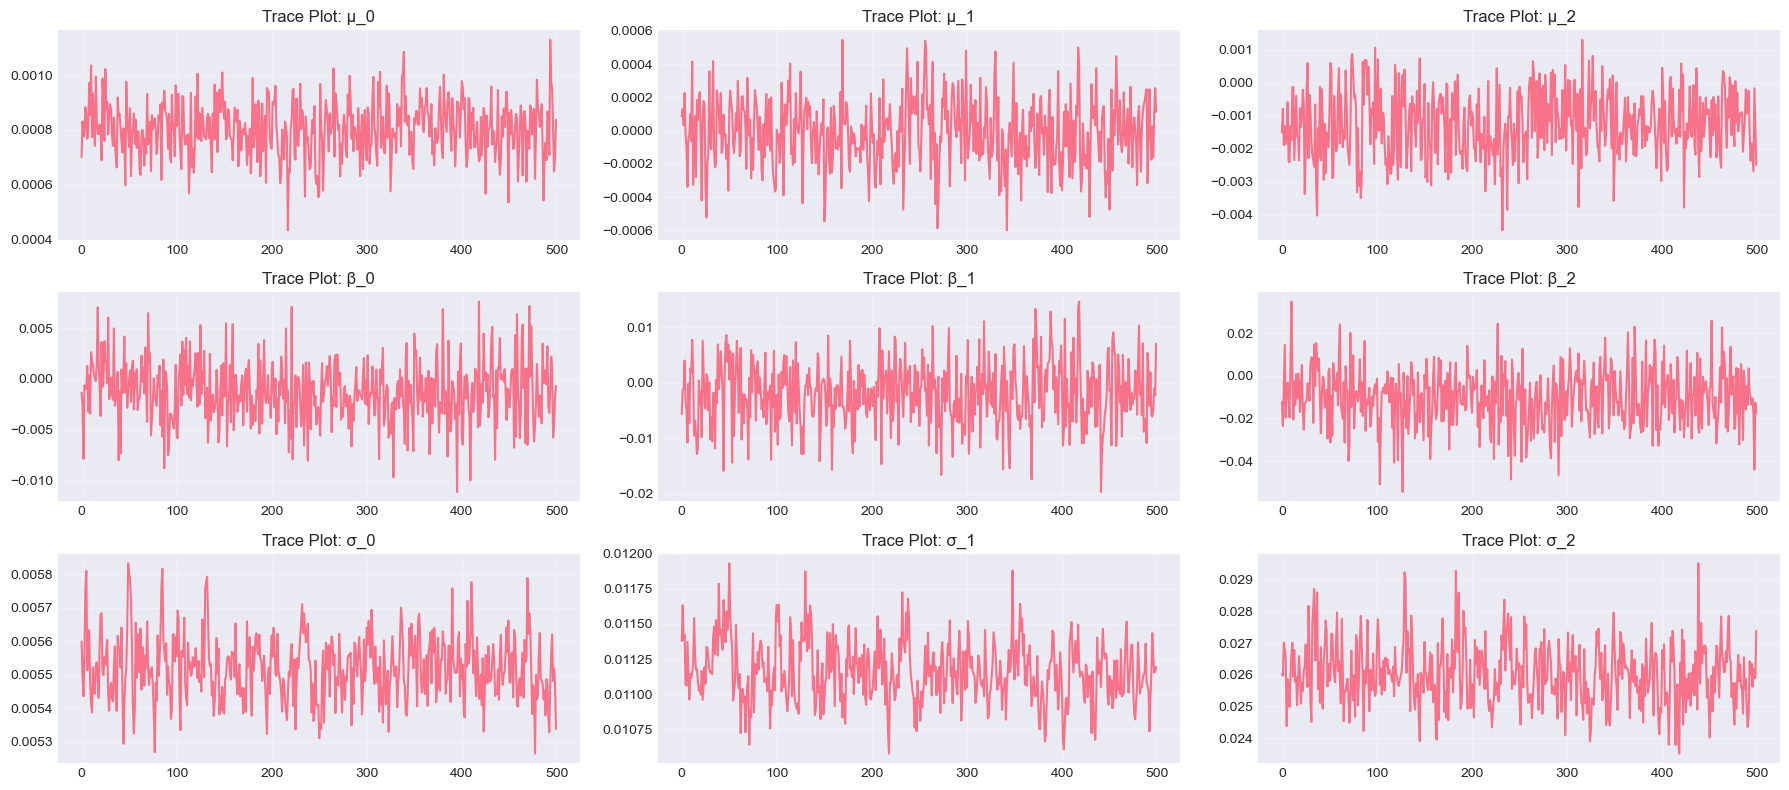

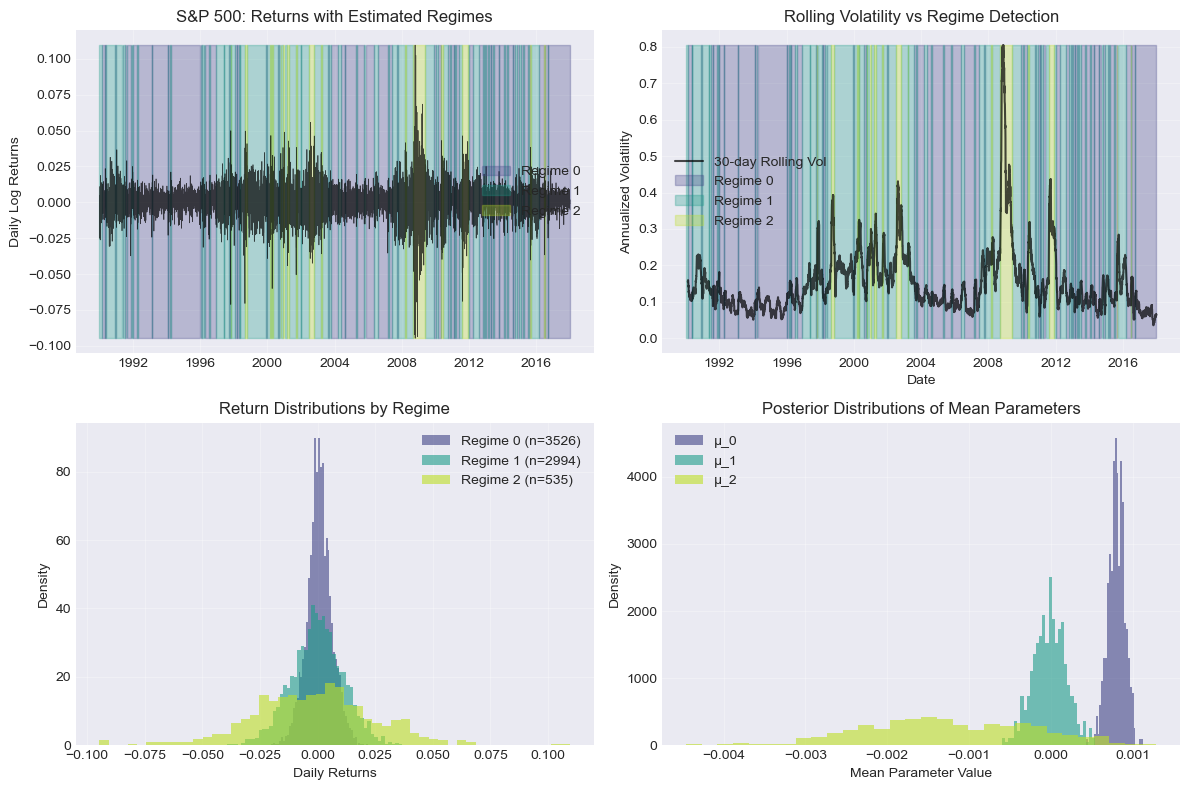

In [21]:
model = MarkovSwitchingModel(n_regimes=3)
model.load_model("saved_models/sp500_MSR_3-regime_100-500-1.pkl")

# Run comprehensive analysis
regime_probs = model.analyze_results(sp500_log_returns, data_name="S&P 500")

# Detailed regime characteristics
regime_classification = model.regime_characteristics(sp500_log_returns, regime_probs, data_name="S&P 500")

# Model diagnostics
model.diagnostics(sp500_log_returns, regime_probs, data_name="S&P 500", trace_plots=True)

# Create visualizations
model.plot_results(sp500_log_returns, regime_probs, data_name="S&P 500")

# Next Section